# Cluster similar regions based on Voronoi frames

In [24]:
import geopandas as gpd
import pandas as pd
import scipy.stats as stats
import shapely
import seaborn as sns
import numpy as np
import libpysal
import spopt
import h3
import matplotlib.pyplot as plt
import os
from glob import glob
import matplotlib.colors
import itertools
from libpysal import graph
from scipy.spatial import distance
from clustergram import Clustergram
from bokeh.io import output_notebook
from bokeh.plotting import show
from sklearn import cluster
from tobler.util import h3fy
from tobler.area_weighted import area_interpolate
from sklearn.metrics import silhouette_score
from spopt.region import SA3

import preprocess_data

Retrieve building dataset and levels of clusters

In [3]:
buildings, levels = preprocess_data.get_buildings("/data/uscuni-boundaries/classification/")

Show area of interest (Central Europe sans Hungary)

<Axes: >

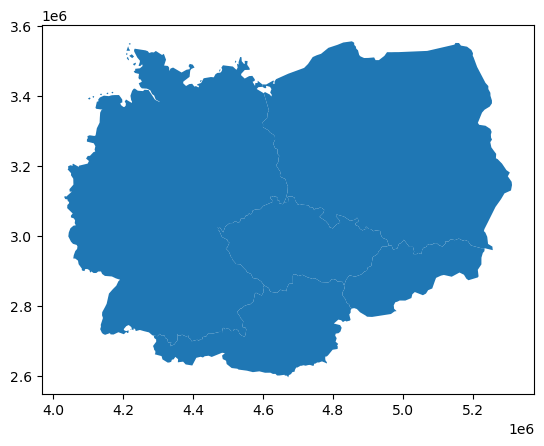

In [4]:
aoi = gpd.read_file("/data/uscuni-boundaries/impact_boundaries.gpkg", layer="1994_political")
aoi.plot()

# Triangulation & Voronoi

Retrieve FUAs

In [5]:
fuas = gpd.read_file('/data/uscuni-boundaries/GHS_FUA_UCDB2015_GLOBE_R2019A_54009_1K_V1_0.gpkg')
fuas

,eFUA_ID,UC_num,UC_IDs,eFUA_name,Commuting,Cntry_ISO,Cntry_name,FUA_area,UC_area,FUA_p_2015,UC_p_2015,Com_p_2015,geometry
0,1.0,1.0,5959,Herat,1.0,AFG,Afghanistan,139.0,60.0,888811.175807,844574.564331,44236.611476,"MULTIPOLYGON (((5529000 4155000, 5531000 41550..."
1,192.0,1.0,5964,Guzarah,1.0,AFG,Afghanistan,32.0,16.0,169489.573231,160204.260864,9285.312366,"MULTIPOLYGON (((5541000 4139000, 5542000 41390..."
2,354.0,1.0,5968,Shindand,0.0,AFG,Afghanistan,12.0,12.0,147553.403870,147553.403870,0.000000,"MULTIPOLYGON (((5573000 4030000, 5574000 40300..."
3,505.0,1.0,5970,Qala i Naw,0.0,AFG,Afghanistan,3.0,3.0,79809.722656,79809.722656,0.000000,"MULTIPOLYGON (((5592000 4221000, 5590000 42210..."
4,648.0,1.0,5973,Farah,1.0,AFG,Afghanistan,32.0,16.0,131508.797060,122843.460327,8665.336733,"MULTIPOLYGON (((5607000 3923000, 5608000 39230..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9026,1739.0,1.0,4191,Triangle,0.0,ZWE,Zimbabwe,5.0,5.0,61859.251465,61859.251465,0.000000,"MULTIPOLYGON (((3023000 -2577000, 3021000 -257..."
9027,1908.0,1.0,4206,Glenclova,0.0,ZWE,Zimbabwe,4.0,4.0,158476.038086,158476.038086,0.000000,"MULTIPOLYGON (((3033000 -2449000, 3032000 -244..."
9028,2062.0,1.0,4222,Bindura,1.0,ZWE,Zimbabwe,54.0,16.0,109737.644325,74992.162598,34745.481728,"MULTIPOLYGON (((3053000 -2126000, 3054000 -212..."
9029,2137.0,1.0,4236,Marondera,1.0,ZWE,Zimbabwe,23.0,12.0,61332.544647,52538.743042,8793.801605,"MULTIPOLYGON (((3067000 -2235000, 3065000 -223..."


In [6]:
target_countries = ['DEU', 'CZE', 'AUT', 'POL', 'SVK']

In [7]:
fuas = fuas[fuas.Cntry_ISO.isin(target_countries)]
fuas = fuas.to_crs(epsg=3035)
#fuas.explore()

In [8]:
triangulation = graph.Graph.build_triangulation(fuas.centroid, method="gabriel", )

In [9]:
#triangulation.explore(fuas.centroid)

Code from `05_cities.ipynb`

In [10]:
%%time
regions = gpd.read_parquet('/data/uscuni-ulce/regions/cadastre_regions_hull.parquet')
mapping = pd.read_parquet(
    f"/data/uscuni-ulce/processed_data/clusters/cluster_mapping_v10.pq"
)
results = []

for region_id in regions.index:

    region_buildings = gpd.read_parquet(f'/data/uscuni-ulce/processed_data/clusters/clusters_{region_id}_v10.pq')

    # assign polygons to only one fua
    inp, res = region_buildings.sindex.query(fuas.geometry, predicate='intersects')
    # polygons should be assigned to only one fua
    duplicated = pd.Series(res).duplicated()
    inp = inp[~duplicated]
    res = res[~duplicated]

    # keep only fua buildings and record  fua 'country', 'city', 'population'
    region_buildings = region_buildings.iloc[res]
    region_buildings.loc[:, ['city', 'country', 'population']] = fuas.iloc[inp, [3, 5, 9]].values

    results.append(region_buildings)

all_fua_buildings = pd.concat(results, ignore_index=True)

CPU times: user 1min 49s, sys: 12.9 s, total: 2min 2s
Wall time: 1min 55s


In [11]:
level = 7
subset = all_fua_buildings[['country', 'city', 'final_without_noise']]

if level < 7:
    subset.loc[:, 'final_without_noise'] = subset.final_without_noise.map(mapping[level].to_dict())


res = subset.groupby(['country', 'city', 'final_without_noise'])['final_without_noise'].count()
res = res.unstack(-1).fillna(0).astype(int)

# normalise based on counts
# note: normalisation can be based on building area too
X = res.values / res.sum(axis=1).values[:, np.newaxis]

In [ ]:
# %%time
# agg = cluster.AgglomerativeClustering(n_clusters=20, connectivity=triangulation.sparse, metric=distance.braycurtis, linkage='single')
# agg.fit(X)

CPU times: user 4.71 ms, sys: 104 μs, total: 4.82 ms
Wall time: 4.73 ms


AgglomerativeClustering(connectivity=<Compressed Sparse Row sparse array of dtype 'float64'
	with 548 stored elements and shape (136, 136)>,
                        linkage='single',
                        metric=<function braycurtis at 0x79e58f9e44a0>,
                        n_clusters=20)

<Axes: >

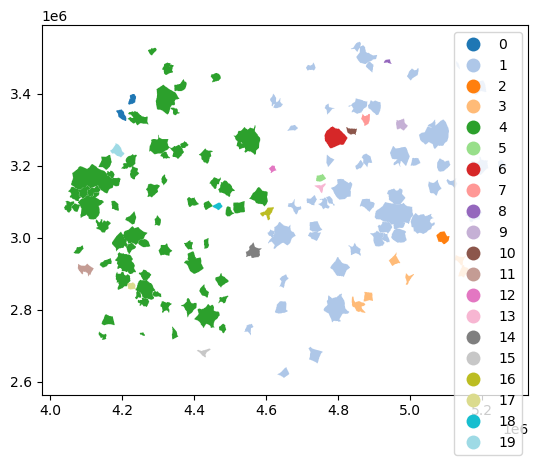

In [ ]:
# fuas.plot(column=agg.labels_, categorical=True, cmap="tab20", legend=True)

In [12]:
df = pd.DataFrame(X, index=fuas.index)

# Cluster variants

In [14]:
df

,0,1,2,3,4,5,6,7,8,9,...,100,101,102,103,104,105,106,107,108,109
252,0.004170,0.007475,0.018818,0.004790,0.010837,0.003720,0.000000,0.0,0.0,0.001547,...,0.004414,0.000728,0.002719,0.000108,0.002913,0.002457,0.008493,0.000000,0.000000,0.000000
253,0.012702,0.007402,0.035818,0.010616,0.012483,0.004425,0.000000,0.0,0.0,0.000000,...,0.002624,0.000353,0.005299,0.000000,0.005636,0.013678,0.055821,0.003382,0.001548,0.004475
254,0.011990,0.007633,0.028854,0.017307,0.006856,0.004129,0.000000,0.0,0.0,0.000000,...,0.003062,0.000244,0.000000,0.000000,0.005804,0.005454,0.024025,0.000000,0.000000,0.000000
255,0.017096,0.012052,0.018666,0.012424,0.006570,0.009475,0.000000,0.0,0.0,0.002657,...,0.011636,0.002475,0.003701,0.001007,0.003482,0.004964,0.014943,0.000540,0.000000,0.000000
256,0.015428,0.010680,0.023740,0.016226,0.010597,0.001362,0.000000,0.0,0.0,0.001927,...,0.012510,0.001872,0.009358,0.000000,0.017299,0.005436,0.030016,0.001197,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7673,0.014625,0.029216,0.013351,0.008270,0.004554,0.014922,0.000335,0.0,0.0,0.001719,...,0.010516,0.003122,0.001513,0.002188,0.001077,0.012139,0.013729,0.002361,0.010420,0.008131
7674,0.026708,0.012899,0.008864,0.005524,0.000402,0.005955,0.000000,0.0,0.0,0.000881,...,0.005299,0.004544,0.000960,0.002723,0.001195,0.006004,0.003350,0.000000,0.002644,0.000118
7675,0.012437,0.028605,0.006233,0.004390,0.003497,0.003658,0.000000,0.0,0.0,0.000059,...,0.000600,0.000000,0.000512,0.000761,0.000029,0.004492,0.005604,0.001039,0.001858,0.000000
7676,0.011633,0.006164,0.007580,0.007092,0.002869,0.006506,0.001514,0.0,0.0,0.001636,...,0.003430,0.000769,0.000000,0.002710,0.002368,0.008947,0.003515,0.009863,0.009399,0.006482


In [15]:
clusterer = SA3(df, triangulation, attrs_name=df.columns.values, min_cluster_size=6, extraction='leaf', metric=distance.braycurtis, linkage='single')
clusterer.solve()

<Axes: >

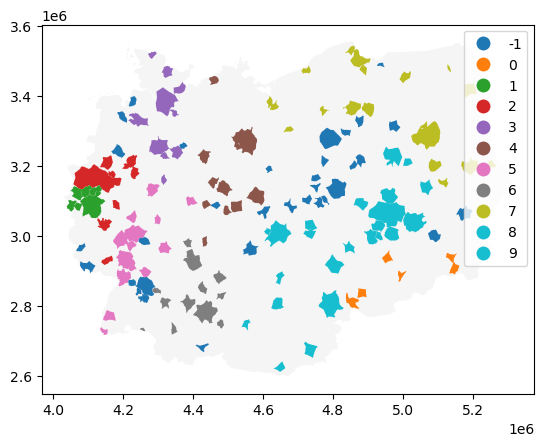

In [16]:
ax = aoi.plot(color="whitesmoke")
fuas.plot(ax=ax, column=clusterer.labels_, categorical=True, legend=True)

In [17]:
dissolved_fuas = fuas.dissolve(by=clusterer.labels_)
dissolved_fuas = dissolved_fuas.drop([-1])
dissolved_fuas

,geometry,eFUA_ID,UC_num,UC_IDs,eFUA_name,Commuting,Cntry_ISO,Cntry_name,FUA_area,UC_area,FUA_p_2015,UC_p_2015,Com_p_2015
0,"MULTIPOLYGON (((4842518.337 2830446.923, 48434...",163.0,1.0,3069,Bratislava,1.0,SVK,Slovakia,833.0,117.0,5.233605e+05,3.520020e+05,1.713585e+05
1,"POLYGON ((4074251.872 3092044.357, 4081731.62 ...",44.0,2.0,2245;2235,Heerlen,1.0,DEU,Germany,532.0,111.0,5.445587e+05,2.931652e+05,2.513935e+05
2,"MULTIPOLYGON (((4170291.876 2937202.583, 41700...",536.0,2.0,2276;2353,Dortmund,1.0,DEU,Germany,6303.0,1423.0,5.837625e+06,3.691645e+06,2.145980e+06
3,"MULTIPOLYGON (((4320015.343 3168741.492, 43199...",2877.0,3.0,2422;2431;2439,Bremen,1.0,DEU,Germany,1287.0,200.0,8.688432e+05,5.063416e+05,3.625016e+05
4,"MULTIPOLYGON (((4440531.462 2981994.476, 44404...",4553.0,1.0,2748,Magdeburg,1.0,DEU,Germany,840.0,78.0,3.382579e+05,1.937056e+05,1.445523e+05
5,"MULTIPOLYGON (((4139905.981 2736307.79, 413980...",2227.0,1.0,2392,Basel,1.0,DEU,Germany,266.0,31.0,1.756185e+05,7.529602e+04,1.003225e+05
6,"MULTIPOLYGON (((4260717.029 2733681.951, 42606...",3906.0,1.0,2549,Constance,1.0,DEU,Germany,83.0,22.0,8.029963e+04,5.825741e+04,2.204223e+04
7,"MULTIPOLYGON (((4682007.272 3309647.3, 4682926...",140.0,2.0,2907;2914,Szczecin,1.0,POL,Poland,684.0,97.0,4.862453e+05,3.258754e+05,1.603699e+05
8,"MULTIPOLYGON (((4657922.763 2635256.217, 46578...",199.0,1.0,2885,Salzburg,1.0,AUT,Austria,368.0,46.0,2.610628e+05,1.400522e+05,1.210107e+05
9,"MULTIPOLYGON (((4912648.763 3016122.111, 49126...",1389.0,1.0,3120,Ostrava,1.0,CZE,CzechRepublic,1043.0,72.0,5.502749e+05,1.865196e+05,3.637554e+05


In [18]:
voronoi =  libpysal.cg.voronoi_frames(dissolved_fuas, return_input=False, shrink=2000, segment=1000)

/tmp/ipykernel_132731/777305694.py:1: FutureWarning: The 'as_gdf' parameter currently defaults to True but will default to False in a future release. Set it explicitly to avoid this warning.
  voronoi =  libpysal.cg.voronoi_frames(dissolved_fuas, return_input=False, shrink=2000, segment=1000)


In [19]:
voronoi

,geometry
0,"POLYGON ((4844735.846 2771932.401, 4844053.518..."
1,"POLYGON ((4054193.148 3143264.983, 4054750.837..."
2,"POLYGON ((4081651.428 2847616.083, 4042167.23 ..."
3,"POLYGON ((4311130.223 3142154.564, 4309142.95 ..."
4,"POLYGON ((4431316.324 2953634.157, 4415875.787..."
5,"POLYGON ((4081651.428 2847616.083, 4092088.681..."
6,"POLYGON ((4214799.749 2627824.489, 4204171.829..."
7,"POLYGON ((5217038.465 3051502.579, 5216126.303..."
8,"POLYGON ((4515629.662 2622061.758, 4516059.07 ..."
9,"POLYGON ((5007437.754 2952837.581, 5001924.633..."


<Axes: >

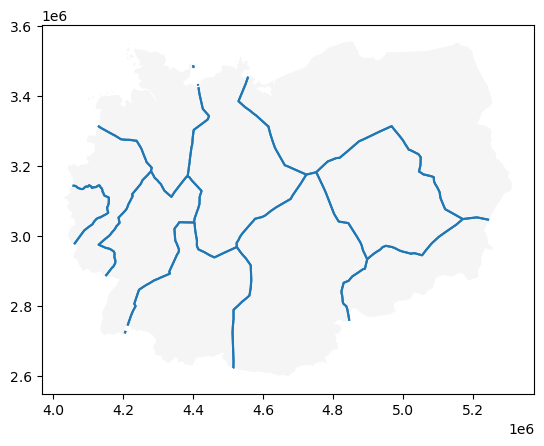

In [20]:
optimal_boundaries = gpd.clip(voronoi, aoi)
ax = optimal_boundaries.boundary.difference(optimal_boundaries.union_all().boundary).plot()
aoi.plot(ax=ax, color="whitesmoke")

In [21]:
clusterer = SA3(df, triangulation, attrs_name=df.columns.values, min_cluster_size=6, extraction='eom', metric=distance.braycurtis, linkage='average')
clusterer.solve()

<Axes: >

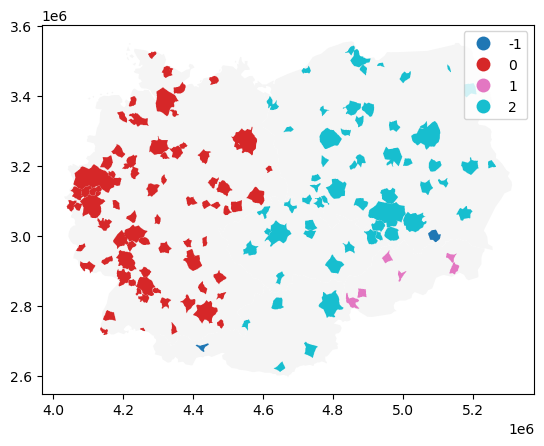

In [22]:
ax = aoi.plot(color="whitesmoke")
fuas.plot(ax=ax, column=clusterer.labels_, categorical=True, legend=True)

In [23]:
dissolved_fuas = fuas.dissolve(by=clusterer.labels_)
dissolved_fuas = dissolved_fuas.drop([-1])

In [24]:
voronoi =  libpysal.cg.voronoi_frames(dissolved_fuas, return_input=False, shrink=1000, segment=500)

/tmp/ipykernel_123178/271934043.py:1: FutureWarning: The 'as_gdf' parameter currently defaults to True but will default to False in a future release. Set it explicitly to avoid this warning.
  voronoi =  libpysal.cg.voronoi_frames(dissolved_fuas, return_input=False, shrink=1000, segment=500)


<Axes: >

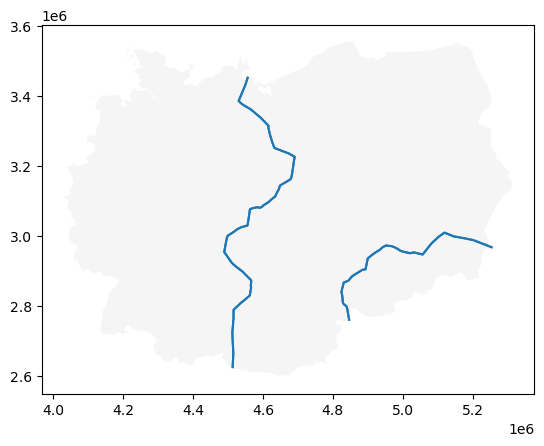

In [25]:
optimal_boundaries = gpd.clip(voronoi, aoi)
ax = optimal_boundaries.boundary.difference(optimal_boundaries.union_all().boundary).plot()
aoi.plot(ax=ax, color="whitesmoke")

In [27]:
clusterer = SA3(df, triangulation, attrs_name=df.columns.values, min_cluster_size=13, extraction='leaf', metric=distance.braycurtis, linkage='single')
clusterer.solve()

<Axes: >

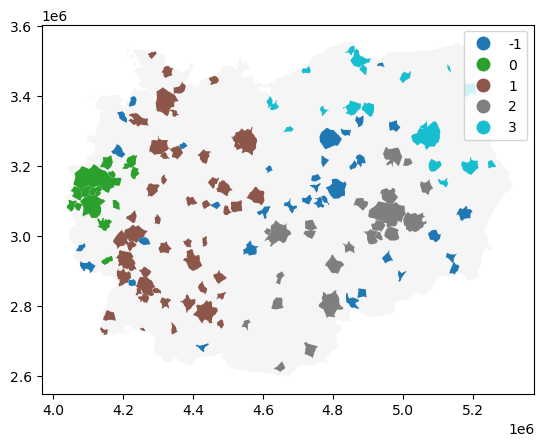

In [28]:
ax = aoi.plot(color="whitesmoke")
fuas.plot(ax=ax, column=clusterer.labels_, categorical=True, legend=True)

In [29]:
dissolved_fuas = fuas.dissolve(by=clusterer.labels_)
dissolved_fuas = dissolved_fuas.drop([-1])

In [30]:
voronoi =  libpysal.cg.voronoi_frames(dissolved_fuas, return_input=False, shrink=1000, segment=500)

/tmp/ipykernel_121283/271934043.py:1: FutureWarning: The 'as_gdf' parameter currently defaults to True but will default to False in a future release. Set it explicitly to avoid this warning.
  voronoi =  libpysal.cg.voronoi_frames(dissolved_fuas, return_input=False, shrink=1000, segment=500)


<Axes: >

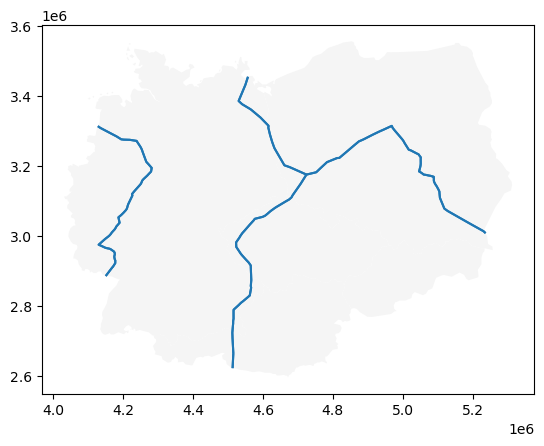

In [31]:
optimal_boundaries = gpd.clip(voronoi, aoi)
ax = optimal_boundaries.boundary.difference(optimal_boundaries.union_all().boundary).plot()
aoi.plot(ax=ax, color="whitesmoke")

In [32]:
clusterer = AZP(df, triangulation.to_W(), attrs_name=df.columns, n_clusters=4)
clusterer.solve()

<Axes: >

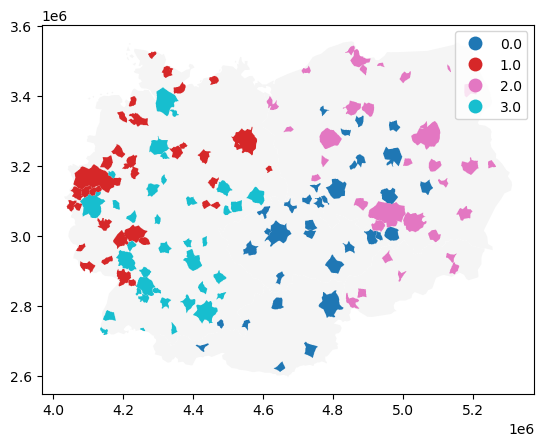

In [33]:
ax = aoi.plot(color="whitesmoke")
fuas.plot(ax=ax, column=clusterer.labels_, categorical=True, legend=True)

In [34]:
dissolved_fuas = fuas.dissolve(by=clusterer.labels_)

In [35]:
voronoi =  libpysal.cg.voronoi_frames(dissolved_fuas, return_input=False, shrink=500, segment=100)

/tmp/ipykernel_121283/2257978305.py:1: FutureWarning: The 'as_gdf' parameter currently defaults to True but will default to False in a future release. Set it explicitly to avoid this warning.
  voronoi =  libpysal.cg.voronoi_frames(dissolved_fuas, return_input=False, shrink=500, segment=100)


<Axes: >

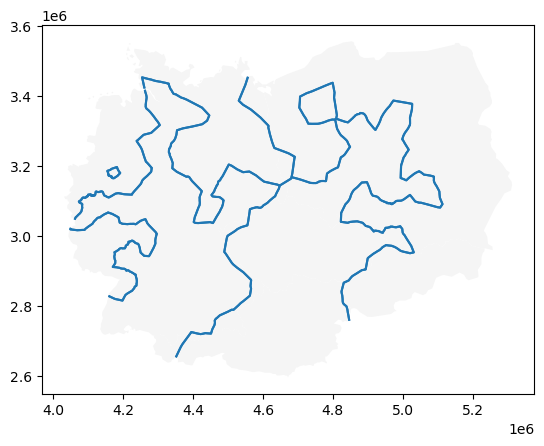

In [36]:
optimal_boundaries = gpd.clip(voronoi, aoi)
ax = optimal_boundaries.boundary.difference(optimal_boundaries.union_all().boundary).plot()
aoi.plot(ax=ax, color="whitesmoke")

In [37]:
clusterer = SA3(df, triangulation, attrs_name=df.columns.values, min_cluster_size=10, extraction='leaf', metric=distance.braycurtis, linkage='single')
clusterer.solve()

<Axes: >

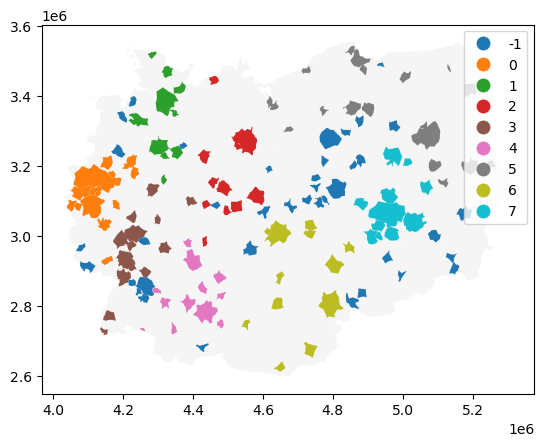

In [38]:
ax = aoi.plot(color="whitesmoke")
fuas.plot(ax=ax, column=clusterer.labels_, categorical=True, legend=True)

In [39]:
dissolved_fuas = fuas.dissolve(by=clusterer.labels_)
dissolved_fuas = dissolved_fuas.drop([-1])

In [40]:
voronoi =  libpysal.cg.voronoi_frames(dissolved_fuas, return_input=False, shrink=500, segment=100)

/tmp/ipykernel_121283/2257978305.py:1: FutureWarning: The 'as_gdf' parameter currently defaults to True but will default to False in a future release. Set it explicitly to avoid this warning.
  voronoi =  libpysal.cg.voronoi_frames(dissolved_fuas, return_input=False, shrink=500, segment=100)


<Axes: >

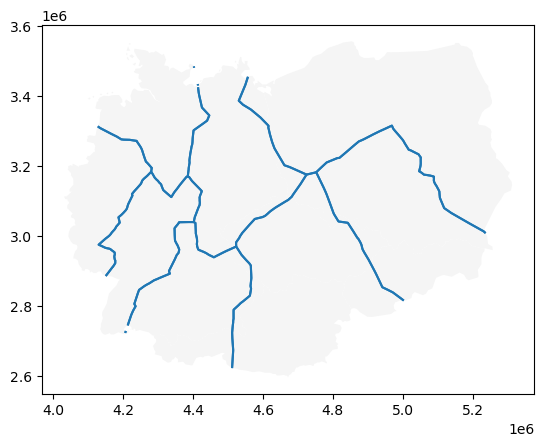

In [41]:
optimal_boundaries = gpd.clip(voronoi, aoi)
ax = optimal_boundaries.boundary.difference(optimal_boundaries.union_all().boundary).plot()
aoi.plot(ax=ax, color="whitesmoke")

# Silhouettes

In [13]:
def get_silhouette_score_per_clustering(df, min_c_size_list, extractions_list, linkages_list):
    results = []

    param_grid = itertools.product(min_c_size_list, extractions_list, linkages_list)

    for min_c_size, extraction, linkage in param_grid:
        clusterer = SA3(df, triangulation, attrs_name=df.columns.values, min_cluster_size=min_c_size, extraction=extraction, metric=distance.braycurtis, linkage=linkage)
        clusterer.solve()
        df_for_clusterer = df[clusterer.labels_ > -1]
        labels_for_clusterer = clusterer.labels_[clusterer.labels_ > -1]
        score = silhouette_score(df_for_clusterer, labels_for_clusterer, metric=distance.braycurtis)
        n_clusters = len(labels_for_clusterer.unique())

        results.append({
            'min_cluster_size': min_c_size,
            'extraction': extraction,
            'linkage': linkage,
            "score": score,
            "n_clusters": n_clusters})

        print(f"Score for combination {min_c_size, extraction, linkage}: {score} (n. of clusters: {n_clusters})")

    return results

In [14]:
min_c_size = range(4,15)
extractions = ["eom", "leaf"]
linkages = ["single", "average", "complete"]

In [15]:
results = get_silhouette_score_per_clustering(df, min_c_size, extractions, linkages)

Score for combination (4, 'eom', 'single'): 0.252745684142944 (n. of clusters: 3)
Score for combination (4, 'eom', 'average'): 0.252745684142944 (n. of clusters: 3)
Score for combination (4, 'eom', 'complete'): -0.06631576724761767 (n. of clusters: 11)
Score for combination (4, 'leaf', 'single'): -0.0481050799558971 (n. of clusters: 14)
Score for combination (4, 'leaf', 'average'): -0.04318879047266112 (n. of clusters: 13)
Score for combination (4, 'leaf', 'complete'): -0.055162291298227153 (n. of clusters: 14)
Score for combination (5, 'eom', 'single'): 0.252745684142944 (n. of clusters: 3)
Score for combination (5, 'eom', 'average'): 0.252745684142944 (n. of clusters: 3)
Score for combination (5, 'eom', 'complete'): -0.03555616544188793 (n. of clusters: 10)
Score for combination (5, 'leaf', 'single'): -0.009803607612699156 (n. of clusters: 11)
Score for combination (5, 'leaf', 'average'): -0.012774140976752437 (n. of clusters: 11)
Score for combination (5, 'leaf', 'complete'): -0.030

In [16]:
results_df = pd.DataFrame(results)

<Axes: xlabel='n_clusters', ylabel='score'>

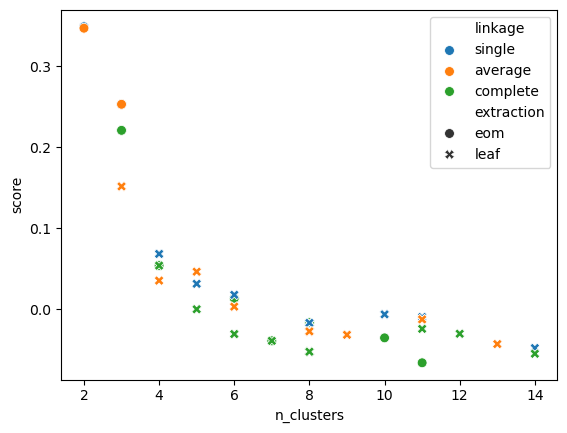

In [17]:
sns.scatterplot(
    data=results_df,
    x='n_clusters',
    y='score',
    hue='linkage',
    style='extraction',
    s=50,
)

In [19]:
results_df.to_csv("/data/uscuni-boundaries/silhouette_scores.csv")

In [20]:
results_df

,min_cluster_size,extraction,linkage,score,n_clusters
0,4,eom,single,0.252746,3
1,4,eom,average,0.252746,3
2,4,eom,complete,-0.066316,11
3,4,leaf,single,-0.048105,14
4,4,leaf,average,-0.043189,13
...,...,...,...,...,...
61,14,eom,average,0.346647,2
62,14,eom,complete,0.053650,4
63,14,leaf,single,0.068066,4
64,14,leaf,average,0.151357,3


In [18]:
results_of_interest = results_df[results_df["n_clusters"].isin([4, 5, 6])]

In [19]:
results_of_interest = results_of_interest.sort_values(by=['n_clusters']).reset_index()

In [23]:
results_of_interest

,index,min_cluster_size,extraction,linkage,score,n_clusters
0,62,14,eom,complete,0.053650,4
1,58,13,leaf,average,0.035109,4
2,63,14,leaf,single,0.068066,4
3,65,14,leaf,complete,0.053650,4
4,57,13,leaf,single,0.068066,4
5,56,13,eom,complete,0.053650,4
6,52,12,leaf,average,0.046112,5
7,51,12,leaf,single,0.031195,5
8,59,13,leaf,complete,-0.000245,5
9,47,11,leaf,complete,-0.030844,6


In [20]:
def plot_generated_clusters(df, cluster_params_df, show_boundaries=True):
    fig, axs = plt.subplots(5,3, figsize=(25,20))
    axs = axs.flatten()
    for index, row in cluster_params_df.iterrows():
        ax = axs[index]
        min_c_size = row["min_cluster_size"]
        extraction = row["extraction"]
        linkage = row["linkage"]
        score = row["score"]
        n_clusters = row["n_clusters"]
        clusterer = SA3(df, triangulation, attrs_name=df.columns.values, min_cluster_size=min_c_size, extraction=extraction, metric=distance.braycurtis, linkage=linkage)
        clusterer.solve()

        dissolved_fuas = fuas.dissolve(by=clusterer.labels_)
        dissolved_fuas = dissolved_fuas.drop([-1])
        voronoi =  libpysal.cg.voronoi_frames(dissolved_fuas, return_input=False, shrink=1000, segment=500, as_gdf=True)

        if show_boundaries:
            optimal_boundaries = gpd.clip(voronoi, aoi)
            ax = optimal_boundaries.boundary.difference(optimal_boundaries.union_all().boundary).plot(ax=ax)
            aoi.plot(ax=ax, color="whitesmoke")

        else:
            ax = aoi.plot(color="whitesmoke")
            fuas.plot(ax=ax, column=clusterer.labels_, categorical=True, legend=True)

        ax.set_title(f"{n_clusters}, {extraction}, {linkage}, score: {score:0.2f},", fontsize=12)
        ax.axis('off')

        plt.tight_layout()


In [21]:
# plot_generated_clusters(df, results_of_interest, show_boundaries=True)

## Run to generate Bray-Curtis matrices for selected clustering results

In [ ]:
from tqdm.auto import tqdm

def generate_bc_matrices_for_cluster_boundaries(cluster_params_df, level_list):
    bc_matrices_path = "/data/uscuni-boundaries/bc_matrices/bc_clusters/"
    if not os.path.exists(bc_matrices_path):
        os.mkdir(bc_matrices_path)

    for index, row in tqdm(cluster_params_df.iterrows(), desc=f"Processing models..."):
        min_c_size = row["min_cluster_size"]
        extraction = row["extraction"]
        linkage = row["linkage"]
        score = row["score"]
        n_clusters = row["n_clusters"]
        clusterer = SA3(df, triangulation, attrs_name=df.columns.values, min_cluster_size=min_c_size, extraction=extraction, metric=distance.braycurtis, linkage=linkage)
        clusterer.solve()

        dissolved_fuas = fuas.dissolve(by=clusterer.labels_)
        dissolved_fuas = dissolved_fuas.drop([-1])
        voronoi =  libpysal.cg.voronoi_frames(dissolved_fuas, return_input=False, shrink=1000, segment=500)

        boundary = gpd.clip(voronoi, aoi)
        print(boundary)
        boundary = boundary.reset_index()
        boundary = boundary.rename(columns={"index": "NAME"})
        print(boundary)
        for level in tqdm(level_list, desc=f"Generating matrices for {n_clusters}_clusters_{linkage}_link_{extraction}"):
            building_counts = preprocess_data.get_building_counts_per_region(buildings, boundary, level)
            building_counts_norm = preprocess_data.normalize_building_counts(building_counts)

            bray_curtis_matrix = preprocess_data.compute_bc_matrix(building_counts_norm)
            output_path = os.path.join(bc_matrices_path, f'bc_{n_clusters}_clusters_{linkage}_link_{extraction}_extract_{level}_lvl.pq')
            bray_curtis_matrix.to_parquet(output_path)

In [22]:
# generate_bc_matrices_for_cluster_boundaries(results_of_interest, levels)

## Boundary diagrams for selected clustering results

In [57]:
results_of_interest['extraction'] = results_of_interest['extraction'].map({'eom': "EoM", 'leaf': "Leaf"})

In [77]:
def generate_boundary_diagrams_for_clusters(cluster_params_df, level="level_7", ax=False, width_multiplier=4, cmap='plasma', ncols=5, nrows=3):
    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(8, 3.5), sharex=True, sharey=True, dpi=300)
    axs = axs.flatten()

    for i, (index, row) in enumerate(cluster_params_df.iterrows()):
        ax = axs[i]
        min_c_size = row["min_cluster_size"]
        extraction = row["extraction"]
        linkage = row["linkage"]
        score = row["score"]
        n_clusters = row["n_clusters"]

        clusterer = SA3(df, triangulation, attrs_name=df.columns.values, min_cluster_size=min_c_size, extraction=extraction.lower(), metric=distance.braycurtis, linkage=linkage)
        clusterer.solve()

        dissolved_fuas = fuas.dissolve(by=clusterer.labels_)
        dissolved_fuas = dissolved_fuas.drop([-1])
        voronoi =  libpysal.cg.voronoi_frames(dissolved_fuas, return_input=False, shrink=1000, segment=500, as_gdf=False)

        boundary = gpd.clip(voronoi, aoi)
        boundary = boundary.reset_index()
        boundary = boundary.rename(columns={"index": "NAME"})

        #Retrieve level-7 BC matrix for layer of interest
        bray_curtis_matrix = pd.read_parquet(f'/data/uscuni-boundaries/bc_matrices/bc_clusters/bc_{n_clusters}_clusters_{linkage}_link_{extraction.lower()}_extract_{level}_lvl.pq')

        #Segment boundaries between adjacent regions
        indices = boundary.sindex.query(boundary.geometry, predicate="intersects")
        left, right = np.unique(np.sort(indices, axis=0), axis=1)

        mask = left == right
        left = left[~mask]
        right = right[~mask]
        geoms = boundary.iloc[left].intersection(boundary.iloc[right], align=False)
        left = boundary.NAME.iloc[left]
        right = boundary.NAME.iloc[right]

        #Retrieve BC dissimilarity values between every two adjacent regions
        border_widths = []
        for l, r in zip(left, right):
            border_widths.append(bray_curtis_matrix.loc[l, r])

        #Recalculate border widths so that higher BC dissimilarity values are emphasized
        line_widths = [(0.1 + width_multiplier*(np.exp(2*w) - 1)) for w in border_widths]

        #Create a colormap to emphasize higher BC dissimilarity values between adjacent regions
        norm=plt.Normalize(0, .7)
        # cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["lightgray","black"])
        if isinstance(cmap, str):
            cmap = matplotlib.colormaps[cmap]

        #Plotting
        if ax:
            for geom, width, border in zip (geoms, line_widths, border_widths):
                gpd.GeoSeries([shapely.line_merge(geom)]).plot(ax=ax, linewidth=width, color=cmap(norm(border)))
                ax.set_title(f"{extraction} | {linkage} | {min_c_size}", fontsize=6)
            aoi.plot(ax=axs[i], color='whitesmoke')
        else:
            fig, ax = plt.subplots(figsize=(20,20))
            ax.set_title(f"{extraction} | {linkage} | {min_c_size}", fontsize=6)
            for geom, width, border in zip (geoms, line_widths, border_widths):
                gpd.GeoSeries([shapely.line_merge(geom)]).plot(ax=ax, linewidth=width, color=cmap(norm(border)))
            aoi.plot(ax=axs[i], color='whitesmoke')

        fig.subplots_adjust(wspace = 0.00, hspace=0.00)
        plt.tight_layout()
    return axs

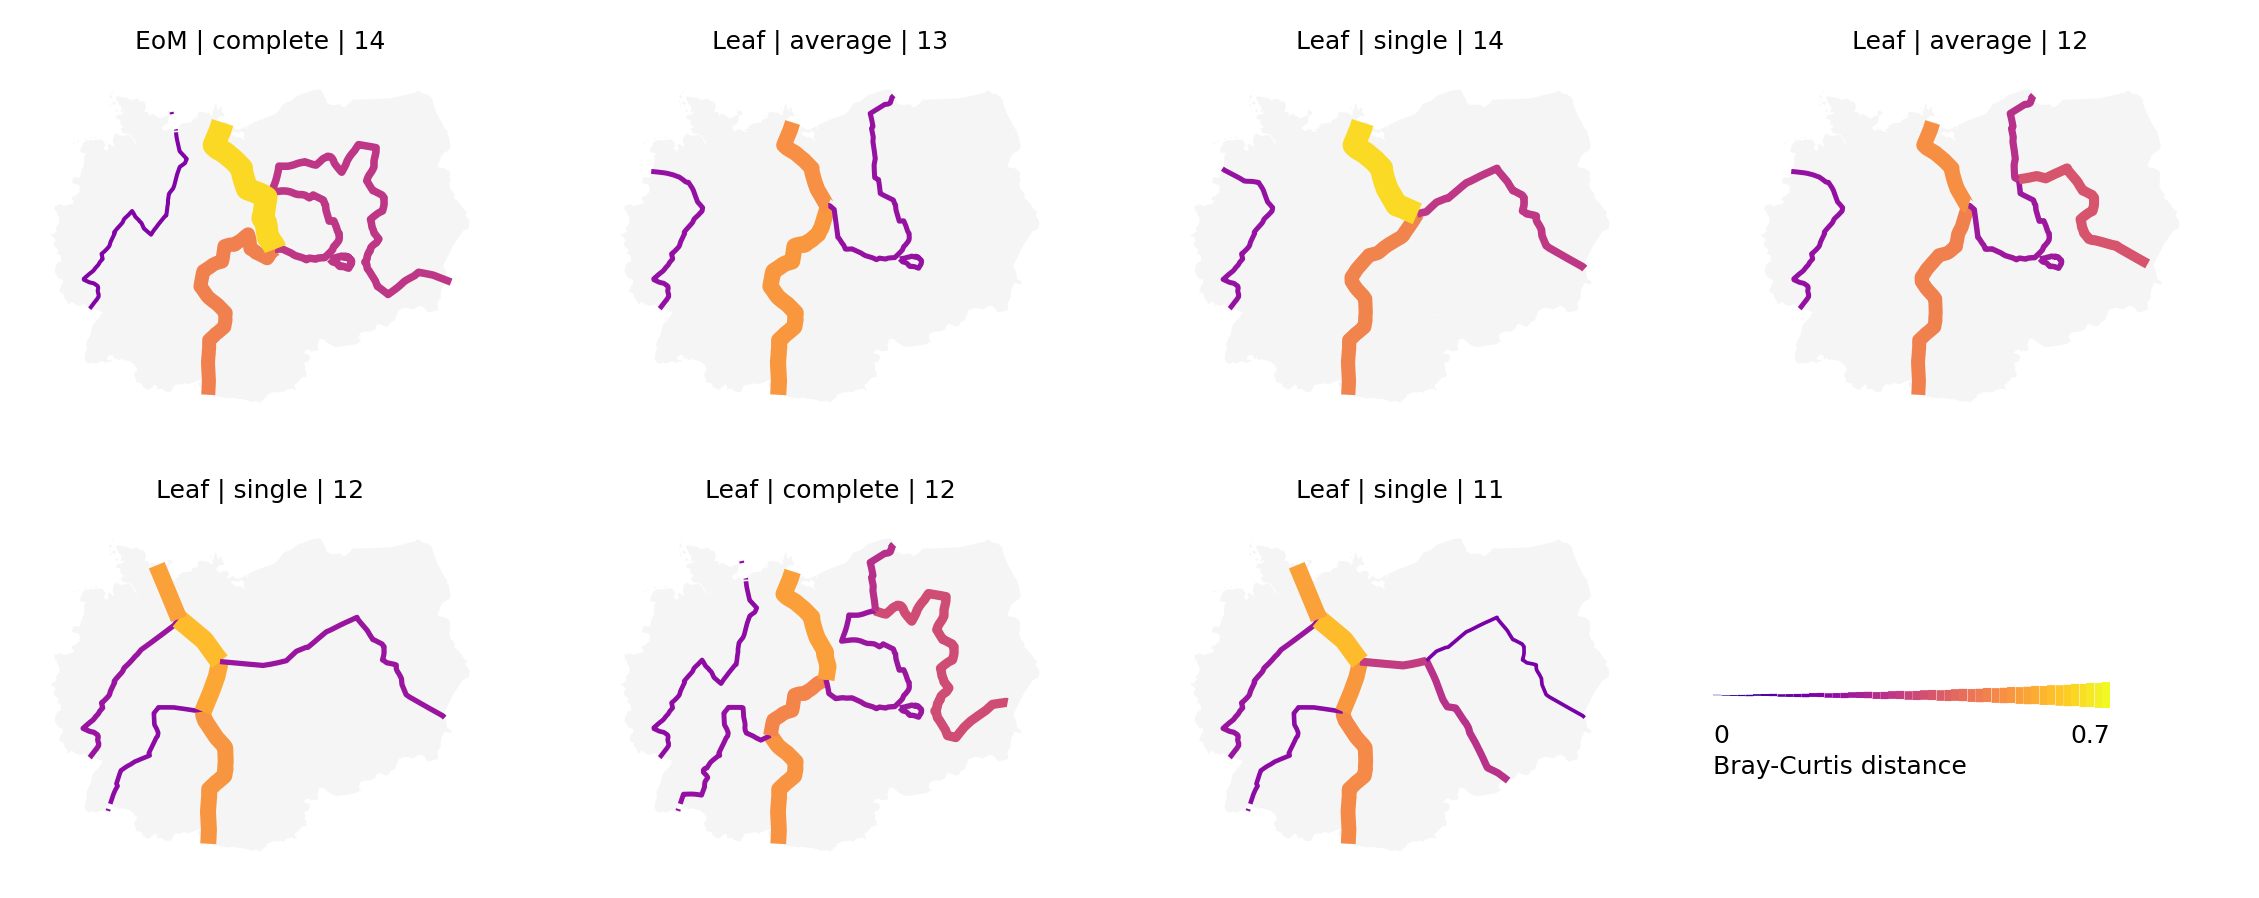

In [80]:
axs = generate_boundary_diagrams_for_clusters(results_of_interest.iloc[[0, 1, 2, 6, 7, 10, 14]], "level_7", cmap='plasma', ncols=4, nrows=2, width_multiplier=2)
for ax in axs.flat:
    ax.set_axis_off()

norm=plt.Normalize(0, .7)
cmap = matplotlib.colormaps['plasma']

bins = 50
for i, d in enumerate(np.linspace(0, .7, bins)):
    axs[-1].plot([i, i+1], [0, 0], linewidth=(0.1 + 2*(np.exp(2*d) - 1)), color=cmap(norm(d)), solid_capstyle='butt')

axs[5]._shared_axes['x'].remove(axs[-1])
axs[-2]._shared_axes['y'].remove(axs[-1])
axs[-1].text(0, -.015, 0, fontdict=dict(fontsize=6))
axs[-1].text(bins - bins *.1, -.015, 0.7, fontdict=dict(fontsize=6))
axs[-1].text(0, -.025, "Bray-Curtis distance", fontdict=dict(fontsize=6))
axs[-1].set_xlim(-.3, bins * 1.3)
plt.savefig('synthetic.png')

In [56]:
results_of_interest

,index,min_cluster_size,extraction,linkage,score,n_clusters
0,62,14,eom,complete,0.053650,4
1,58,13,leaf,average,0.035109,4
2,63,14,leaf,single,0.068066,4
3,65,14,leaf,complete,0.053650,4
4,57,13,leaf,single,0.068066,4
5,56,13,eom,complete,0.053650,4
6,52,12,leaf,average,0.046112,5
7,51,12,leaf,single,0.031195,5
8,59,13,leaf,complete,-0.000245,5
9,47,11,leaf,complete,-0.030844,6
